In [1]:
import pandas as pd
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import Counter
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA

In [2]:
DATA_DIR = 'data'
DATA_FILE = join(DATA_DIR,'covid_data_2.csv')

In [3]:
REF_DATE = pd.to_datetime('2022-01-01')
target_col = 'final_outcome_amp'

In [4]:
SCALE = True
APPLY_PCA = False
FILTER_MI = True
FILTER_CORRELATION = False
FILTER_RF = False

In [5]:
REF_DATE = pd.to_datetime('2022-01-01')
def filter_data_date(data,reference_date = REF_DATE):
    '''For each person (record_id), get only the row with the visit date closest to reference_date'''
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data = data.dropna(subset=['visit_date'],ignore_index = True)
    data = data[data['visit_date'] < reference_date]
    return data.sort_values(by=['record_id','visit_date'],ascending = [True,False]).drop_duplicates(subset=['record_id'], keep='first')#.reset_index()

def filter_by_mutual_information(X, y, k='all'):
    """
    Filters features based on mutual information with the target variable.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        k (int or 'all'): Number of top features to select based on mutual information.
                          If 'all', returns features with MI > 0.

    Returns:
        pd.DataFrame: DataFrame with selected features.
    """
    selector = SelectKBest(mutual_info_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    return X[selected_features]

def filter_by_correlation(X, threshold=0.9):
    """
    Filters features based on pairwise correlation. Removes one feature from
    highly correlated pairs.

    Args:
        X (pd.DataFrame): Feature matrix.
        threshold (float): Correlation threshold above which features are removed.

    Returns:
        pd.DataFrame: DataFrame with features removed based on correlation.
    """
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Dropping {len(to_drop)} features due to high correlation: {to_drop}")
    return X.drop(to_drop, axis=1)

def apply_pca(X, n_components=None):
    """
    Applies Principal Component Analysis (PCA) to the feature matrix.

    Args:
        X (pd.DataFrame): Feature matrix.
        n_components (int, float, or None): Number of components to keep.
            - If int, specifies the number of components.
            - If float (between 0.0 and 1.0), specifies the variance to retain.
            - If None, keeps all components.

    Returns:
        pd.DataFrame: DataFrame with PCA-transformed features.
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    print(f"PCA applied. Explained variance ratio with {pca.n_components_} components: {pca.explained_variance_ratio_.sum():.4f}")
    # Create meaningful column names for PCA components
    pca_cols = [f'PC_{i+1}' for i in range(pca.n_components_)]
    return pd.DataFrame(X_pca, index=X.index, columns=pca_cols)

def filter_by_rf_importance(X, y, k=10, **rf_params):
    """
    Filters features based on Random Forest feature importance.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        k (int): Number of top features to select based on importance.
        **rf_params: Additional parameters to pass to RandomForestClassifier.

    Returns:
        pd.DataFrame: DataFrame with the top k features selected by RF importance.
    """
    # Default RF parameters if not provided
    default_rf_params = {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1}
    default_rf_params.update(rf_params) # Update with user-provided params

    rf = RandomForestClassifier(**default_rf_params)
    rf.fit(X, y)

    importances = pd.Series(rf.feature_importances_, index=X.columns)
    top_k_features = importances.nlargest(k).index
    print(f"Selected top {k} features based on RF importance.")
    return X[top_k_features]

In [6]:
all_data = pd.read_csv(DATA_FILE)
raw_data = filter_data_date(all_data).dropna(axis=1, how='all') #apply date filter and remove empty columns
raw_data.pop('visit_date')
raw_data.set_index('record_id',inplace=True)
raw_data.columns = raw_data.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)
assert (all_data['record_id'].unique() == raw_data.index).all()
#y = raw_data.pop('final_outcome_amp')

In [7]:
def scale(data):
    if SCALE: data = (data - data.mean())/data.std()
    return data
def preprocess_data(df):
    data = pd.get_dummies(df, columns=['timepoint'], dtype=int)
    data['study'] = data['study'].map({data['study'].unique()[0]:0,data['study'].unique()[1]:1})
    data = pd.get_dummies(data, columns=['pop_sample'], dtype=int)
    #data['visit_date'] = (REF_DATE - pd.to_datetime(data['visit_date'], format='%Y-%m-%d')).dt.days
    data['index_date'] = (REF_DATE - pd.to_datetime(data['index_date'], format='%Y-%m-%d')).dt.days
    data['age'] = scale(data['age'])#normalize age?
    data['sex'] = data['sex'].map({data['sex'].unique()[0]:0,data['sex'].unique()[1]:1})
    data['bmi'] = scale(data['bmi']).fillna(data['bmi'].mean())
    data = pd.get_dummies(data, columns=['smoking'], dtype=int) #or adapt to 0, 0.5 and 1?
    data['comorbidity'] = data['comorbidity'].map({data['comorbidity'].unique()[0]:0,data['comorbidity'].unique()[1]:1})
    data['hypertension'] = data['hypertension'].map({data['hypertension'].unique()[0]:0,data['hypertension'].unique()[1]:1})
    data['hypertension'] = data['hypertension'].fillna(data['hypertension'].mean())
    data['diabetes'] = data['diabetes'].map({data['diabetes'].unique()[0]:0,data['diabetes'].unique()[1]:1})
    data['diabetes'] = data['diabetes'].fillna(data['diabetes'].mean())
    data['cvd'] = data['cvd'].map({data['cvd'].unique()[0]:0,data['cvd'].unique()[1]:1})
    data['cvd'] = data['cvd'].fillna(data['cvd'].mean())
    data['respiratory'] = data['respiratory'].map({data['respiratory'].unique()[0]:0,data['respiratory'].unique()[1]:1})
    data['respiratory'] = data['respiratory'].fillna(data['respiratory'].mean())
    data['ckd'] = data['ckd'].map({data['ckd'].unique()[0]:0,data['ckd'].unique()[1]:1})
    data['ckd'] = data['ckd'].fillna(data['ckd'].mean())
    data['cancer'] = data['cancer'].map({data['cancer'].unique()[0]:0, data['cancer'].unique()[1]:1})
    data['cancer'] = data['cancer'].fillna(data['cancer'].mean())
    data['immune_supp'] = data['immune_supp'].map({data['immune_supp'].unique()[0]:0, data['immune_supp'].unique()[1]:1})
    data['immune_supp'] = data['immune_supp'].fillna(data['immune_supp'].mean())
    data = pd.get_dummies(data,columns=['income_3l'], dummy_na=0, dtype=int)#data['income_3l'].map({"<6'000 CHF":0, "6'000 - 12'000 CHF":0.5, ">12'000 CHF":1}).fillna(0.5) ####
    data = pd.get_dummies(data, columns=['employment_4l'], dtype=int)
    data = pd.get_dummies(data,columns=['education_4l'], prefix='education', dummy_na=0, dtype=int)
    data['nationality'] = data['nationality'].map({'Non-Swiss':0,'Swiss':1})
    data['summary_bl_behaviour'] = scale(data['summary_bl_behaviour'])
    data['symp_init'] = data['symp_init'].map({"No":0, "Yes":1})
    data['symp_init'] = data['symp_init'].fillna(data['symp_init'].mean())
    data = pd.get_dummies(data,columns=['symp_count_init_3l'], dummy_na=0, dtype=int) #####
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].map({"Mild to moderate":0, "Severe to very severe":1})
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].fillna(data['symp_sev_init_3l'].mean())
    data['hosp_2wks'] = data['hosp_2wks'].map({"No":0, "Yes":1})
    data['hosp_2wks'] = data['hosp_2wks'].fillna(data['hosp_2wks'].mean())
    data['icu_2wks'] = data['icu_2wks'].map({"No":0, "Yes":1})
    data['icu_2wks'] = data['icu_2wks'].fillna(data['icu_2wks'].mean()) #can discard?
    data['seropos_at_bl'] = data['seropos_at_bl'].map({"No":0, "Yes":1})
    data['seropos_at_bl'] = data['seropos_at_bl'].fillna(data['seropos_at_bl'].mean())
    data['prior_pos_pcr'] = data['prior_pos_pcr'].map({"No":0, "Yes":1})
    data['prior_pos_pcr'] = data['prior_pos_pcr'].fillna(data['prior_pos_pcr'].mean())
    data['prior_exposure'] = data['prior_exposure'].map({"No":0, "Yes":1})
    data['prior_exposure'] = data['prior_exposure'].fillna(data['prior_exposure'].mean())
    data['first_exposure_date'] = (REF_DATE - pd.to_datetime(data['first_exposure_date'], format='%Y-%m-%d')).dt.days; 
    data['first_exposure_date'] = data['first_exposure_date'].fillna(-100)
    data['first_exposure'] = data['first_exposure'].map({data['first_exposure'].unique()[0]:0,data['first_exposure'].unique()[1]:1}).fillna(0.5)
    data= pd.get_dummies(data,columns=['vaccine_type_1'], dummy_na=0, dtype=int)#data['vaccine_type_1'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data = pd.get_dummies(data,columns=['vaccine_type_2'], dummy_na=0, dtype=int)#data['vaccine_type_2'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_3'], dummy_na=0, dtype=int)#data['vaccine_type_3'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_4'], dummy_na=0, dtype=int)#data['vaccine_type_4'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data['pcr_pos_date_1'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_1'], format='%Y-%m-%d')).dt.days; 
    data['pcr_pos_date_1'] = data['pcr_pos_date_1'].fillna(-100)
    data['pcr_pos_date_2'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_2'], format='%Y-%m-%d')).dt.days; 
    data['pcr_pos_date_2'] = data['pcr_pos_date_2'].fillna(data['pcr_pos_date_2'].mean())
    data= pd.get_dummies(data,columns=['pcr_pos_sev_1'], dummy_na=0, dtype=int)#data['pcr_pos_sev_1'].map({"Very mild":1, "Mild":2, "Moderate":3, "Severe":4}).fillna(-1) 
    data['ab_chuv_iga_ratio'] = scale(data['ab_chuv_iga_ratio'])
    data['ab_chuv_iga_result'] = data['ab_chuv_iga_result'].map({data['ab_chuv_iga_result'].unique()[0]:0,data['ab_chuv_iga_result'].unique()[1]:1})
    data['ab_chuv_igg_s_ratio'] = scale(data['ab_chuv_igg_s_ratio'])
    data['ab_chuv_igg_s_result'] = data['ab_chuv_igg_s_result'].map({data['ab_chuv_igg_s_result'].unique()[0]:0,data['ab_chuv_igg_s_result'].unique()[1]:1})
    data['ab_chuv_igg_n_ratio'] = scale(data['ab_chuv_igg_n_ratio'])
    data['ab_chuv_igg_n_result'] = data['ab_chuv_igg_n_result'].map({data['ab_chuv_igg_n_result'].unique()[0]:0,data['ab_chuv_igg_n_result'].unique()[1]:1})
    data['ab_chuv_iga_logratio'] = scale(data['ab_chuv_iga_logratio'])
    data['ab_chuv_igg_s_logratio'] = scale(data['ab_chuv_igg_s_logratio'])
    data['ab_chuv_igg_n_logratio'] = scale(data['ab_chuv_igg_n_logratio'])
    
    # Drop the ratio columns
    data.drop(columns=['ab_chuv_iga_ratio', 'ab_chuv_igg_s_ratio', 'ab_chuv_igg_n_ratio'], inplace=True)
    
    data['last_antibody_before_omicron_iga_logratio'] = scale(data['last_antibody_before_omicron_iga_logratio'])
    data['last_antibody_before_omicron_igg_n_logratio'] = scale(data['last_antibody_before_omicron_igg_n_logratio'])
    data['last_antibody_before_omicron_igg_s_logratio'] = scale(data['last_antibody_before_omicron_igg_s_logratio'])
    data.drop('Unnamed: 0', inplace=True,axis=1)
    data['vaccine_date_1'] = (REF_DATE - pd.to_datetime(data['vaccine_date_1'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_1'] = data['vaccine_date_1'].fillna(-100)
    data['vaccine_date_2'] = (REF_DATE - pd.to_datetime(data['vaccine_date_2'], format='%Y-%m-%d')).dt.days
    data['vaccine_date_2'] = data['vaccine_date_2'].fillna(-100); 
    data['vaccine_date_3'] = (REF_DATE - pd.to_datetime(data['vaccine_date_3'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_3'] = data['vaccine_date_3'].fillna(-100)
    data['vaccine_date_4'] = (REF_DATE - pd.to_datetime(data['vaccine_date_4'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_4'] = data['vaccine_date_4'].fillna(-100)
    data['prior_hyg'] = data['prior_hyg'].fillna(0.)
    data['prior_dist'] = data['prior_hyg'].fillna(0.)
    data['prior_mask_mand'] = data['prior_hyg'].fillna(0.)
    return data

def preprocess_data(df):
    data = pd.get_dummies(df, columns=['timepoint'], dtype=int)
    data['study'] = data['study'].map({data['study'].unique()[0]:0,data['study'].unique()[1]:1})
    data = pd.get_dummies(data, columns=['pop_sample'], dtype=int)
    #data['visit_date'] = (REF_DATE - pd.to_datetime(data['visit_date'], format='%Y-%m-%d')).dt.days
    data['index_date'] = (REF_DATE - pd.to_datetime(data['index_date'], format='%Y-%m-%d')).dt.days
    data['age'] = scale(data['age'])#normalize age?
    data['sex'] = data['sex'].map({data['sex'].unique()[0]:0,data['sex'].unique()[1]:1})
    data['bmi'] = scale(data['bmi']).fillna(data['bmi'].mean())
    data = pd.get_dummies(data, columns=['smoking'], dtype=int) #or adapt to 0, 0.5 and 1?
    data['comorbidity'] = data['comorbidity'].map({data['comorbidity'].unique()[0]:0,data['comorbidity'].unique()[1]:1})
    data['hypertension'] = data['hypertension'].map({data['hypertension'].unique()[0]:0,data['hypertension'].unique()[1]:1})
    data['hypertension'] = data['hypertension'].fillna(data['hypertension'].mean())
    data['diabetes'] = data['diabetes'].map({data['diabetes'].unique()[0]:0,data['diabetes'].unique()[1]:1})
    data['diabetes'] = data['diabetes'].fillna(data['diabetes'].mean())
    data['cvd'] = data['cvd'].map({data['cvd'].unique()[0]:0,data['cvd'].unique()[1]:1})
    data['cvd'] = data['cvd'].fillna(data['cvd'].mean())
    data['respiratory'] = data['respiratory'].map({data['respiratory'].unique()[0]:0,data['respiratory'].unique()[1]:1})
    data['respiratory'] = data['respiratory'].fillna(data['respiratory'].mean())
    data['ckd'] = data['ckd'].map({data['ckd'].unique()[0]:0,data['ckd'].unique()[1]:1})
    data['ckd'] = data['ckd'].fillna(data['ckd'].mean())
    data['cancer'] = data['cancer'].map({data['cancer'].unique()[0]:0, data['cancer'].unique()[1]:1})
    data['cancer'] = data['cancer'].fillna(data['cancer'].mean())
    data['immune_supp'] = data['immune_supp'].map({data['immune_supp'].unique()[0]:0, data['immune_supp'].unique()[1]:1})
    data['immune_supp'] = data['immune_supp'].fillna(data['immune_supp'].mean())
    data = pd.get_dummies(data,columns=['income_3l'], dummy_na=0, dtype=int)#data['income_3l'].map({"<6'000 CHF":0, "6'000 - 12'000 CHF":0.5, ">12'000 CHF":1}).fillna(0.5) ####
    data = pd.get_dummies(data, columns=['employment_4l'], dtype=int)
    data = pd.get_dummies(data,columns=['education_4l'], prefix='education', dummy_na=0, dtype=int)
    data['nationality'] = data['nationality'].map({'Non-Swiss':0,'Swiss':1})
    data['summary_bl_behaviour'] = scale(data['summary_bl_behaviour'])
    data['symp_init'] = data['symp_init'].map({"No":0, "Yes":1})
    data['symp_init'] = data['symp_init'].fillna(data['symp_init'].mean())
    data = pd.get_dummies(data,columns=['symp_count_init_3l'], dummy_na=0, dtype=int) #####
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].map({"Mild to moderate":0, "Severe to very severe":1})
    data['symp_sev_init_3l'] = data['symp_sev_init_3l'].fillna(data['symp_sev_init_3l'].mean())
    data['hosp_2wks'] = data['hosp_2wks'].map({"No":0, "Yes":1})
    data['hosp_2wks'] = data['hosp_2wks'].fillna(data['hosp_2wks'].mean())
    data['icu_2wks'] = data['icu_2wks'].map({"No":0, "Yes":1})
    data['icu_2wks'] = data['icu_2wks'].fillna(data['icu_2wks'].mean()) #can discard?
    data['seropos_at_bl'] = data['seropos_at_bl'].map({"No":0, "Yes":1})
    data['seropos_at_bl'] = data['seropos_at_bl'].fillna(data['seropos_at_bl'].mean())
    data['prior_pos_pcr'] = data['prior_pos_pcr'].map({"No":0, "Yes":1})
    data['prior_pos_pcr'] = data['prior_pos_pcr'].fillna(data['prior_pos_pcr'].mean())
    data['prior_exposure'] = data['prior_exposure'].map({"No":0, "Yes":1})
    data['prior_exposure'] = data['prior_exposure'].fillna(data['prior_exposure'].mean())
    data['first_exposure_date'] = (REF_DATE - pd.to_datetime(data['first_exposure_date'], format='%Y-%m-%d')).dt.days; 
    data['first_exposure_date'] = data['first_exposure_date'].fillna(data['first_exposure_date'].mean())
    data['first_exposure'] = data['first_exposure'].map({data['first_exposure'].unique()[0]:0,data['first_exposure'].unique()[1]:1}).fillna(0.5)
    data= pd.get_dummies(data,columns=['vaccine_type_1'], dummy_na=0, dtype=int)#data['vaccine_type_1'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data = pd.get_dummies(data,columns=['vaccine_type_2'], dummy_na=0, dtype=int)#data['vaccine_type_2'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_3'], dummy_na=0, dtype=int)#data['vaccine_type_3'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1)
    data = pd.get_dummies(data,columns=['vaccine_type_4'], dummy_na=0, dtype=int)#data['vaccine_type_4'].map({"Moderna":0, "Pfizer/BioNTech":1, "Other":0.5}).fillna(-1) 
    data['pcr_pos_date_1'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_1'], format='%Y-%m-%d')).dt.days; 
    data['pcr_pos_date_1'] = data['pcr_pos_date_1'].fillna(data['pcr_pos_date_1'].mean())
    data['pcr_pos_date_2'] = (REF_DATE - pd.to_datetime(data['pcr_pos_date_2'], format='%Y-%m-%d')).dt.days; 
    data['pcr_pos_date_2'] = data['pcr_pos_date_2'].fillna(data['pcr_pos_date_2'].mean())
    data= pd.get_dummies(data,columns=['pcr_pos_sev_1'], dummy_na=0, dtype=int)#data['pcr_pos_sev_1'].map({"Very mild":1, "Mild":2, "Moderate":3, "Severe":4}).fillna(-1) 
    data['ab_chuv_iga_ratio'] = scale(data['ab_chuv_iga_ratio'])
    data['ab_chuv_iga_result'] = data['ab_chuv_iga_result'].map({data['ab_chuv_iga_result'].unique()[0]:0,data['ab_chuv_iga_result'].unique()[1]:1})
    data['ab_chuv_igg_s_ratio'] = scale(data['ab_chuv_igg_s_ratio'])
    data['ab_chuv_igg_s_result'] = data['ab_chuv_igg_s_result'].map({data['ab_chuv_igg_s_result'].unique()[0]:0,data['ab_chuv_igg_s_result'].unique()[1]:1})
    data['ab_chuv_igg_n_ratio'] = scale(data['ab_chuv_igg_n_ratio'])
    data['ab_chuv_igg_n_result'] = data['ab_chuv_igg_n_result'].map({data['ab_chuv_igg_n_result'].unique()[0]:0,data['ab_chuv_igg_n_result'].unique()[1]:1})
    data['ab_chuv_iga_logratio'] = scale(data['ab_chuv_iga_logratio'])
    data['ab_chuv_igg_s_logratio'] = scale(data['ab_chuv_igg_s_logratio'])
    data['ab_chuv_igg_n_logratio'] = scale(data['ab_chuv_igg_n_logratio'])
    
    # Drop the ratio columns
    data.drop(columns=['ab_chuv_iga_ratio', 'ab_chuv_igg_s_ratio', 'ab_chuv_igg_n_ratio'], inplace=True)
    
    data['last_antibody_before_omicron_iga_logratio'] = scale(data['last_antibody_before_omicron_iga_logratio'])
    data['last_antibody_before_omicron_igg_n_logratio'] = scale(data['last_antibody_before_omicron_igg_n_logratio'])
    data['last_antibody_before_omicron_igg_s_logratio'] = scale(data['last_antibody_before_omicron_igg_s_logratio'])
    data.drop('Unnamed: 0', inplace=True,axis=1)
    data['vaccine_date_1'] = (REF_DATE - pd.to_datetime(data['vaccine_date_1'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_1'] = data['vaccine_date_1'].fillna(-100)
    data['vaccine_date_2'] = (REF_DATE - pd.to_datetime(data['vaccine_date_2'], format='%Y-%m-%d')).dt.days
    data['vaccine_date_2'] = data['vaccine_date_2'].fillna(-100); 
    data['vaccine_date_3'] = (REF_DATE - pd.to_datetime(data['vaccine_date_3'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_3'] = data['vaccine_date_3'].fillna(-100)
    data['vaccine_date_4'] = (REF_DATE - pd.to_datetime(data['vaccine_date_4'], format='%Y-%m-%d')).dt.days; 
    data['vaccine_date_4'] = data['vaccine_date_4'].fillna(-100)
    data['prior_hyg'] = data['prior_hyg'].fillna(0.)
    data['prior_dist'] = data['prior_hyg'].fillna(0.)
    data['prior_mask_mand'] = data['prior_hyg'].fillna(0.)
    data['study'] = df['study'].map({df['study'].unique()[0]:0,df['study'].unique()[1]:1})
    data['final_outcome_amp'] = df['final_outcome_amp']
    data['index_date'] = (REF_DATE - pd.to_datetime(df['index_date'], format='%Y-%m-%d')).dt.days



    pcr_pos_date = (REF_DATE - pd.to_datetime(df['pcr_pos_date_1'], format='%Y-%m-%d')).dt.days.fillna(-100)
    data['pcr_pos_date'] = pcr_pos_date
    data['age'] = scale(df['age'])
    data['bmi'] = scale(df['bmi'])
    data['bmi'] = data['bmi'].fillna(data['bmi'].mean())

    data['comorbidity'] = df['comorbidity'].map({df['comorbidity'].unique()[0]:0,df['comorbidity'].unique()[1]:1})
    data['first_exposure_date'] = (REF_DATE - pd.to_datetime(df['first_exposure_date'], format='%Y-%m-%d')).dt.days.fillna(500)
    data['num_vaccines'] = raw_data[['vaccine_date_1', 'vaccine_date_2', 'vaccine_date_3', 'vaccine_date_4']].notna().sum(axis=1)

    data['ab_chuv_igg_s_logratio'] = scale(df['ab_chuv_igg_s_logratio'])
    data['ab_chuv_igg_n_logratio'] = scale(df['ab_chuv_igg_n_logratio'])
    data['ab_chuv_iga_logratio'] = scale(df['ab_chuv_iga_logratio'])
    data['first_exposure'] = df['first_exposure'].map({df['first_exposure'].unique()[0]:0,df['first_exposure'].unique()[1]:1}).fillna(0.5)
    data['prior_exposure'] = df['prior_exposure'].map({df['prior_exposure'].unique()[0]:0,df['prior_exposure'].unique()[1]:1}).fillna(0.5)
    data['last_antibody_before_omicron_igg_n_logratio'] = scale(df['last_antibody_before_omicron_igg_n_logratio'])
    return data



In [8]:
data = preprocess_data(raw_data)

In [9]:
print(f"Final dataset shape: {data.shape}")
print("\nMissing values:", data.isna().sum().sum())
print("Column dtypes:\n", data.dtypes.value_counts())
print("\nTarget distribution:\n", data['final_outcome_amp'].value_counts(normalize=True))

Final dataset shape: (710, 91)

Missing values: 0
Column dtypes:
 int64      50
float64    41
Name: count, dtype: int64

Target distribution:
 final_outcome_amp
0    0.628169
1    0.371831
Name: proportion, dtype: float64


# Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Stratified split to preserve class balance
X = data.drop('final_outcome_amp', axis=1)
X.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]
y = data['final_outcome_amp']

print(f"Shape before filtering: {X.shape}")

# Apply feature selection based on flags
if FILTER_MI:
    # Select features with MI > 0 (k='all' selects based on score > 0)
    # Or specify k=N to select top N features
    print("Applying Mutual Information filter...")
    X = filter_by_mutual_information(X, y, k=30)
    print(f"Shape after MI filter: {X.shape}")

if FILTER_CORRELATION:
    print("\nApplying Correlation filter...")
    X = filter_by_correlation(X, threshold=0.9)
    print(f"Shape after Correlation filter: {X.shape}")

if FILTER_RF:
    # Select top k features based on RF importance
    # Adjust k as needed
    k_rf = 30
    print(f"\nApplying Random Forest Importance filter (top {k_rf} features)...")
    X = filter_by_rf_importance(X, y, k=k_rf)
    print(f"Shape after RF Importance filter: {X.shape}")

if APPLY_PCA:
    # Apply PCA, retaining e.g., 95% of variance
    n_components_pca = 0.95
    print(f"\nApplying PCA (n_components={n_components_pca})...")
    X = apply_pca(X, n_components=n_components_pca)
    print(f"Shape after PCA: {X.shape}")

print(f"\nFinal shape of features X: {X.shape}")
# Ensure y aligns with the filtered X (indices should match)
y = y.loc[X.index]
print(f"Final shape of target y: {y.shape}")

# Initial split (80% train/val, 20% test)

Shape before filtering: (710, 90)
Applying Mutual Information filter...
Shape after MI filter: (710, 90)

Final shape of features X: (710, 90)
Final shape of target y: (710,)


/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
219 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hep/lprate/miniconda3/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/hep/lprate/miniconda3/lib/python3.12/site-packages/xgboost/sklearn.py", line 1663, in fit
    train_dmatrix, e

XGBoostError: [01:40:48] /workspace/src/data/array_interface.cu:44: Check failed: err == cudaGetLastError() (0 vs. 2) : 
Stack trace:
  [bt] (0) /home/hep/lprate/miniconda3/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x2a6acc) [0x7fd1bfea6acc]
  [bt] (1) /home/hep/lprate/miniconda3/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0xb84c1c) [0x7fd1c0784c1c]
  [bt] (2) /home/hep/lprate/miniconda3/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x5649ce) [0x7fd1c01649ce]
  [bt] (3) /home/hep/lprate/miniconda3/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0x10b) [0x7fd1bfdb3a5b]
  [bt] (4) /home/hep/lprate/miniconda3/lib/python3.12/lib-dynload/../../libffi.so.8(+0xa052) [0x7fd34a653052]
  [bt] (5) /home/hep/lprate/miniconda3/lib/python3.12/lib-dynload/../../libffi.so.8(+0x8925) [0x7fd34a651925]
  [bt] (6) /home/hep/lprate/miniconda3/lib/python3.12/lib-dynload/../../libffi.so.8(ffi_call+0xde) [0x7fd34a65206e]
  [bt] (7) /home/hep/lprate/miniconda3/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x134a9) [0x7fd34a66d4a9]
  [bt] (8) /home/hep/lprate/miniconda3/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x8b31) [0x7fd34a662b31]



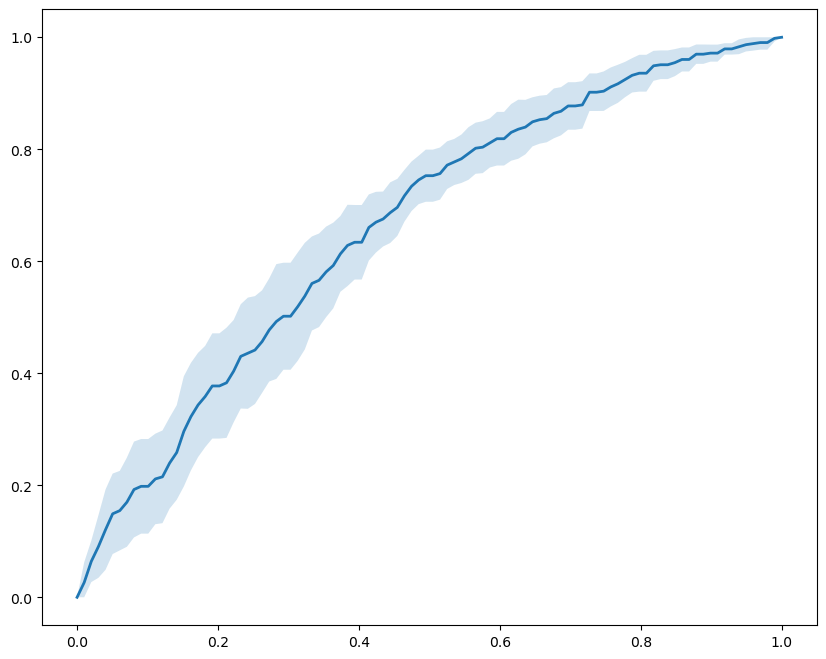

In [11]:


# Use stratified K-Fold for cross-validation (inner loop)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'bootstrap': [True, False],
            'n_estimators': [20, 100, 200, 500],
            'max_depth': [None, 10, 20, 40],
            'min_samples_split': [5, 7, 10, 12, 20, 50],
            'min_samples_leaf': [2, 5, 8],
            'class_weight': ['balanced', None]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss',tree_method='hist'),
        'param_grid': {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [3, 5],
            'reg_lambda': [0, 0.1, 1],
            'min_child_weight': [1, 3, 5, 10],  
            'scale_pos_weight': [1, (len(y)-sum(y))/sum(y)]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, solver='liblinear'),
        'param_grid': {
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10],
            'class_weight': ['balanced', None]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'param_grid': {
            'max_depth': [2, 5, 15, 20],
            'min_samples_leaf': [2, 25, 50],
        }
    },
    'LinearDiscriminantAnalysis': {
        'model': LinearDiscriminantAnalysis(),
        'param_grid': {
            'solver': ['svd', 'lsqr', 'eigen'],
            'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
            'tol': [1e-4, 1e-3, 1e-2],
        }
    }
}

# Number of random train-test splits
n_splits = 10
test_size = 0.2  # 20% test set

plt.figure(figsize=(10, 8))
best_models = {}
accuracy_scores = {}
auc_scores = {}
balanced_accuracy_scores = {}
feature_importances = {}
optimal_parameters = {}  # Dictionary to store optimal parameters

for model_name, config in models.items():
    tprs = []
    aucs = []
    accuracies = []
    balanced_accuracies = []
    mean_fpr = np.linspace(0, 1, 100)
    optimal_parameters[model_name] = []  # Initialize list to store parameters from each split
    
    for split in range(n_splits):
        # Create random train-test split while preserving class distribution
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42+split, stratify=y
        )
        
        # Inner loop for GridSearchCV
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['param_grid'],
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Store optimal parameters for this split
        optimal_parameters[model_name].append(grid_search.best_params_)
        
        # Use best model from last split as the overall best model
        best_models[model_name] = best_model
        
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc_score(y_test, y_proba))
        
        accuracies.append(accuracy_score(y_test, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        
        # Save feature importances for RandomForest
        if model_name == 'RandomForest':
            if split == n_splits - 1:  # Save only from the last split
                feature_importances[model_name] = best_model.feature_importances_
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{model_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)
    
    auc_scores[model_name] = (mean_auc, std_auc)
    accuracy_scores[model_name] = (np.mean(accuracies), np.std(accuracies))
    balanced_accuracy_scores[model_name] = (np.mean(balanced_accuracies), np.std(balanced_accuracies))

# Plot formatting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for All Models (10 Random 80-20 Splits)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# Print optimal hyperparameters for each model
print("\n=== Optimal Hyperparameters ===")
for model_name, params_list in optimal_parameters.items():
    print(f"\n** {model_name} **")
    
    # Create a summary of parameter frequency across splits
    # For each parameter, find the most common value
    param_summary = {}
    for param_name in params_list[0].keys():
        param_values = [split_params[param_name] for split_params in params_list]
        value_counts = Counter(param_values)
        most_common_value = value_counts.most_common(1)[0][0]
        param_summary[param_name] = most_common_value
    
    # Print the most common parameter values
    for param, value in param_summary.items():
        print(f"{param}: {value}")

# Print test set metrics for the last split
print("\n=== Test Set Metrics (Last Split) ===")
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\n** {model_name} **")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print accuracy and balanced accuracy across all splits
print("\n=== Accuracy and Balanced Accuracy (All Splits) ===")
for model_name in models.keys():
    acc_mean, acc_std = accuracy_scores[model_name]
    bal_acc_mean, bal_acc_std = balanced_accuracy_scores[model_name]
    print(f"\n** {model_name} **")
    print(f"Accuracy: {acc_mean:.2f} ± {acc_std:.2f}")
    print(f"Balanced Accuracy: {bal_acc_mean:.2f} ± {bal_acc_std:.2f}")

# Print feature importances for RandomForest (from the last split)
if 'RandomForest' in feature_importances:
    print("\n=== Feature Importances for RandomForest (Last Split) ===")
    feature_importance_dict = dict(zip(X.columns, feature_importances['RandomForest']))
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")

In [ ]:
auc_scores